In [208]:
import pandas as pd
import numpy as np
import os
import nltk
import random

In [209]:
import itertools
import pickle
from pathlib import Path
import matplotlib.pyplot as plt
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from keras.models import Sequential
from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical
from keras.preprocessing.text import Tokenizer
from keras.models import Sequential, Model
from keras.layers import Activation, Dense, Dropout
# from keras.callbacks import EarlyStopping

from sklearn.preprocessing import LabelBinarizer
import sklearn.datasets as skds
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
# from sklearn.feature_extraction.text import CountVectorizer

In [210]:
## Load data from CSV file to dataframe

# df_sentiment = pd.read_csv("./sentiment_gop_cleaned.csv", engine='python')
df_sentiment = pd.read_csv("./cleaned_airline_sentiment.csv", engine='python')
# df_sentiment.drop(['Unnamed: 0'], axis=1, inplace=True)
# print(df_gop.shape)
df_sentiment.head()

,tweet_id,tweet_created,sentiment,full_text,cleaned_text
0,570301130888122368,2015-02-24 11:15:59 -0800,non-negative,@VirginAmerica plus you've added commercials to the experience... tacky.,plus you have added commercials to the experience tacky
1,570301083672813571,2015-02-24 11:15:48 -0800,non-negative,@VirginAmerica I didn't today... Must mean I need to take another trip!,i did not today must mean i need to take another trip
2,570301031407624196,2015-02-24 11:15:36 -0800,negative,"@VirginAmerica it's really aggressive to blast obnoxious ""entertainment"" in your guests' faces &amp; they have little recourse",it is really aggressive to blast obnoxious entertainment in your guests faces they have little recourse
3,570300817074462722,2015-02-24 11:14:45 -0800,negative,@VirginAmerica and it's a really big bad thing about it,and it is a really big bad thing about it
4,570300767074181121,2015-02-24 11:14:33 -0800,negative,@VirginAmerica seriously would pay $30 a flight for seats that didn't have this playing.\nit's really the only bad thing about flying VA,seriously would pay $30 a flight for seats that did not have this playing it is really the only bad thing about flying va


In [211]:
df_sentiment['sentiment'].value_counts()

negative        8822
non-negative    4402
Name: sentiment, dtype: int64

In [212]:
# df_sentiment = df_sentiment.sort_values(by=['sentiment'])
# df_sentiment.reset_index(drop=True)
# df_sentiment= df_sentiment.iloc[3000:]
# df_sentiment = df_sentiment.sample(frac=1).reset_index(drop=True)
# df_sentiment['sentiment'].value_counts()

In [213]:
# df_sentiment['sentiment'] = pd.Categorical(df_sentiment['sentiment'], ["Neutral", "Negative", "Positive"])
# df_sentiment = df_sentiment.sort_values(by=['sentiment'])
# df_sentiment.reset_index(drop=True)
# df_sentiment= df_sentiment.iloc[700:]
# df_sentiment = df_sentiment.sample(frac=1).reset_index(drop=True)
# df_sentiment['sentiment'].value_counts()
def change_vals(row):
    if row == 'Neutral' or row == 'Positive':
        return "Non-Negative"
    else:
        return row
df_sentiment['sentiment'] = df_sentiment['sentiment'].apply(change_vals)

In [214]:
data = df_sentiment
data['sentiment'].value_counts()

negative        8822
non-negative    4402
Name: sentiment, dtype: int64

In [215]:
max_len = 130
num_labels = 2
vocab_size = 4000
batch_size = 32
num_epochs = 10
embed_dim = 128
lstm_out = 196

tokenizer = Tokenizer(num_words=vocab_size, split=' ')
tokenizer.fit_on_texts(data['cleaned_text'].values)
X = tokenizer.texts_to_sequences(data['cleaned_text'].values)
X = pad_sequences(X)
Y = pd.get_dummies(data['sentiment']).values

print(len(data['sentiment'].values))
arr_y = np.array(Y)

sanity_check = {'text': data['cleaned_text'].values, 'sentiment': data['sentiment'].values, 'negative':arr_y[:,0], 'non-negative': arr_y[:,1]}
sanity_check = pd.DataFrame(data=sanity_check)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.33, random_state = 42)

encoder = LabelBinarizer()
encoder.fit(Y)

13224


LabelBinarizer(neg_label=0, pos_label=1, sparse_output=False)

In [216]:
sanity_check.sample(50)

,text,sentiment,negative,non-negative
11575,envoy airlines is a disgrace to the aa family nothing but delays and cancelled flightlations week after week,negative,1,0
1270,i just checked my united app and the most valuable use of this app has been removed i can no longer see the status of my equipment,negative,1,0
3549,next thing you know united will believe they are above the dot and take them to court united is anticonsumer,negative,1,0
13076,the bad weather was not a surprise you should have doubletriple staff on hand to handle calls way to treat your customers,negative,1,0
1263,on top of that i paid for 1st class and my wife got stuck in coach,negative,1,0
7036,ah no the staff was perfect this morning at jfk more sleep for me,non-negative,0,1
8868,you all need to get it together,non-negative,0,1
4484,we have been at the gate a long time we are going to miss our connection at mdw ack,negative,1,0
3499,we have been told that it is lostyou guys do not know where it is,negative,1,0
6801,what can i say other than when it comes to my brandloveaffair w ur my soulandinspiration umosaicmecrazy,non-negative,0,1


In [217]:
X_train.shape, Y_train.shape

((8860, 89), (8860, 2))

In [218]:
print(sum(Y_test))

[130 138]


In [219]:
# #let us build a basic model
# model = Sequential()
# model.add(Dense(512, input_shape=(vocab_size,)))
# model.add(Activation('relu'))
# model.add(Dropout(0.3))
# model.add(Dense(512))
# model.add(Activation('relu'))
# model.add(Dropout(0.3))
# model.add(Dense(num_labels))
# model.add(Activation('softmax'))
# model.summary()

# model.compile(loss='categorical_crossentropy',
#               optimizer='adam',
#               metrics=['accuracy'])

model = Sequential()
model.add(Embedding(vocab_size, embed_dim,input_length = X.shape[1]))
model.add(SpatialDropout1D(0.4))
model.add(LSTM(lstm_out, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(num_labels,activation='softmax'))
model.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])
print(model.summary())

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 89, 128)           512000    
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 89, 128)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 196)               254800    
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 394       
Total params: 767,194
Trainable params: 767,194
Non-trainable params: 0
_________________________________________________________________
None


In [220]:
# num_epochs = 10
# batch_size = 128
# history = model.fit(X_train, Y_train,
#                     batch_size=batch_size,
#                     epochs=num_epochs,
#                     verbose=2,
#                     validation_split=0.2)

model.fit(X_train, Y_train, epochs=num_epochs, batch_size=batch_size, verbose=2)


Epoch 1/10
 - 23s - loss: 0.4670 - accuracy: 0.7807
Epoch 2/10
 - 22s - loss: 0.3296 - accuracy: 0.8562
Epoch 3/10
 - 23s - loss: 0.2706 - accuracy: 0.8876
Epoch 4/10
 - 26s - loss: 0.2262 - accuracy: 0.9087
Epoch 5/10
 - 27s - loss: 0.1992 - accuracy: 0.9192
Epoch 6/10
 - 24s - loss: 0.1651 - accuracy: 0.9339
Epoch 7/10
 - 25s - loss: 0.1460 - accuracy: 0.9433
Epoch 8/10
 - 24s - loss: 0.1292 - accuracy: 0.9479
Epoch 9/10
 - 23s - loss: 0.1105 - accuracy: 0.9563
Epoch 10/10
 - 24s - loss: 0.0973 - accuracy: 0.9632


In [222]:
score, acc = model.evaluate(X_test, Y_test, batch_size=batch_size, verbose=2)

print('Classification Accuracy on Test Set:', acc * 100, '%')

Classification Accuracy on Test Set: 81.0265839099884 %


In [223]:
text_labels = encoder.classes_

res_dict = {'predicted': [] }
for i in range(len(X_test)):
    prediction = model.predict(np.array([X_test[i]]))
    predicted_label = text_labels[np.argmax(prediction[0])]
    res_dict['predicted'].append(predicted_label)

df_res = pd.DataFrame(data=res_dict)
df_res['predictedLabel'] = ["Non-Negative" if y == 1 else "Negative" for y in df_res['predicted']]
df_res['actual'] = ["Non-Negative" if y.tostring() == np.asarray([0, 1], dtype=np.uint8).tostring() else "Negative" for y in Y_test]

print(df_res['predicted'].value_counts())
print(df_res['actual'].value_counts())

df_res.head()


0    2988
1    1376
Name: predicted, dtype: int64
Negative        2946
Non-Negative    1418
Name: actual, dtype: int64


,predicted,predictedLabel,actual
0,1,Non-Negative,Non-Negative
1,0,Negative,Negative
2,0,Negative,Negative
3,1,Non-Negative,Non-Negative
4,0,Negative,Negative


In [224]:
## Reverse the tokenized vectors to re-generate the cleaned versions of tweets

reverseTokenizerDict = dict(map(reversed, tokenizer.word_index.items()))
predTweets = []
for i in X_test:
    s = ""
    for j in i:
        if j != 0:
            s += reverseTokenizerDict[j] + " "
    predTweets.append(s)
        
df_res['generatedCleanTweets'] = predTweets

In [225]:
pd.options.display.max_colwidth = 100
df_res.head(25)

,predicted,predictedLabel,actual,generatedCleanTweets
0,1,Non-Negative,Non-Negative,thank you excited to be working with you guys
1,0,Negative,Negative,thank you for letting me luggage is still in denver but i am in phl neveragain disappointed
2,0,Negative,Negative,for our delays i am out of more money because of you
3,1,Non-Negative,Non-Negative,so the fares i see for flights in fall are the lowest they will be
4,0,Negative,Negative,understand weather is an issue but on time cancelled flighted reinstated cancelled flighted with...
5,0,Negative,Negative,why can not i find a cheap flight from dc to st louis the prices went up like crazy for april
6,0,Negative,Negative,service today missed my connecting flight then the customer service desk was terrible to me real...
7,0,Negative,Negative,status shows delayed it was just waiting for takeoff so did it depart it certainly did not at
8,0,Negative,Negative,i booked it on us airways site do not see a cancelled flight link
9,0,Negative,Negative,what is happening with the flight from fll to sfo why the delay and the reroute


In [226]:
## Find accuracy of predictions on class-by-class basis
negs = df_res.loc[df_res['actual'] == "Negative"]
nons = df_res.loc[df_res['actual'] == "Non-Negative"]

accNegs = sum(np.where(negs['predictedLabel'] == "Negative", 1, 0)) / negs.shape[0] * 100
accNons = sum(np.where(nons['predictedLabel'] == "Non-Negative", 1, 0)) / nons.shape[0] * 100

print("Classification Accuracy on Negative Data: ", accNegs, "%")
print("Classification Accuracy on Non-Negative Data: ", accNons, "%")


Classification Accuracy on Negative Data:  86.65987780040734 %
Classification Accuracy on Non-Negative Data:  69.32299012693936 %


## Covid Mask Twitter Data

In [238]:
df_masks = pd.read_csv('combined_cleaned_covid_mask_sample.csv')
df_masks.shape

(124277, 5)

In [239]:
df_masks = df_masks.astype({'created_at': 'datetime64' })

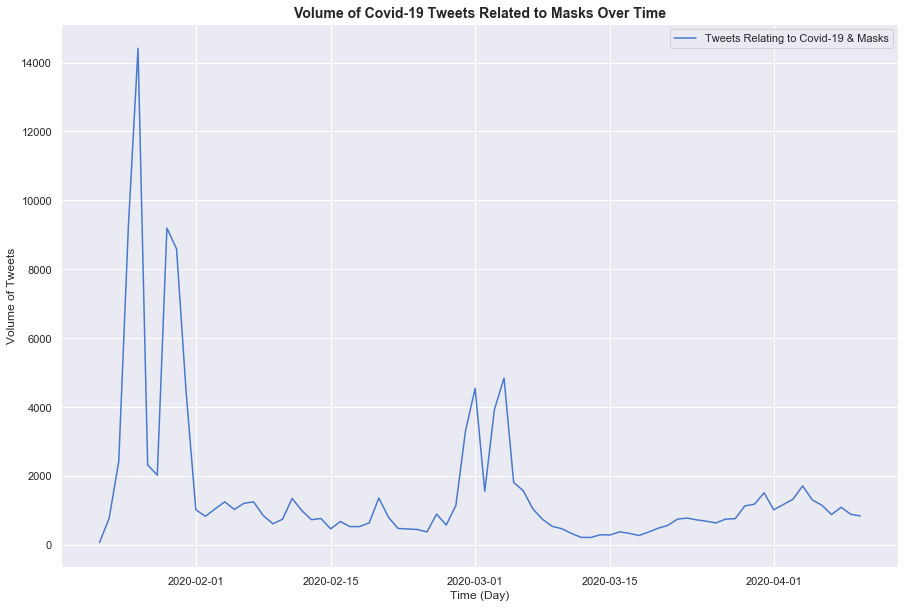

In [240]:
plt.figure(figsize=(15,10))
df_mask_vol = pd.DataFrame(pd.to_datetime(df_masks['created_at']).dt.floor('d').value_counts().rename_axis('created_at').reset_index(name='count')).set_index('created_at')
df_mask_vol = df_mask_vol.sort_index()
plt.plot(df_mask_vol)
plt.title('Volume of Covid-19 Tweets Related to Masks Over Time', fontsize=14, fontweight="bold")
plt.xlabel('Time (Day)')
plt.ylabel('Volume of Tweets')
plt.legend(['Tweets Relating to Covid-19 & Masks'])
plt.savefig('mask_tweet_volume_graph.png', dpi=300)

# Tweet Frequency Distribution

In [243]:
pd.set_option("display.max_colwidth", 300)
df_tweet_freq = pd.DataFrame(np.array(FreqDist(df_masks['cleaned_text']).most_common(25)), columns = ['tweet', 'frequency'])
df_tweet_freq.head(50)

,tweet,frequency
0,how to wear a mask coronavirus,9303
1,psa facial mask is not effective against wuhan virus,7791
2,wearing a face mask does help if you do it properly seto wing hong of hong kong university demonstrates the correct way to…,4649
3,900 people get coronavirus and the whole world wants to wear surgical mask 30 million people have aids but still nobody wan…,3507
4,how to wear mask pls share this so that many people can learn the correct way coronavirus coronaoutbreak coronavirusout…,2108
5,scientists you should wash your hands because of coronavirus people i am going to stop flying hoard masks work from home t…,1929
6,a man in china left 500 face masks at a police station then jogged off before officers could thank him …,1594
7,just 1 case of corona virus in india and people are crazy for masks daily 400 people die in road crashes still no…,1155
8,ok ncov has been confirmed in the philippines pls always wear your masks and do the handwashing techniques and you all mask…,871
9,wearing a face mask does help if you do it properly seto wing hong of hong kong university demonstrates the correct wa…,858


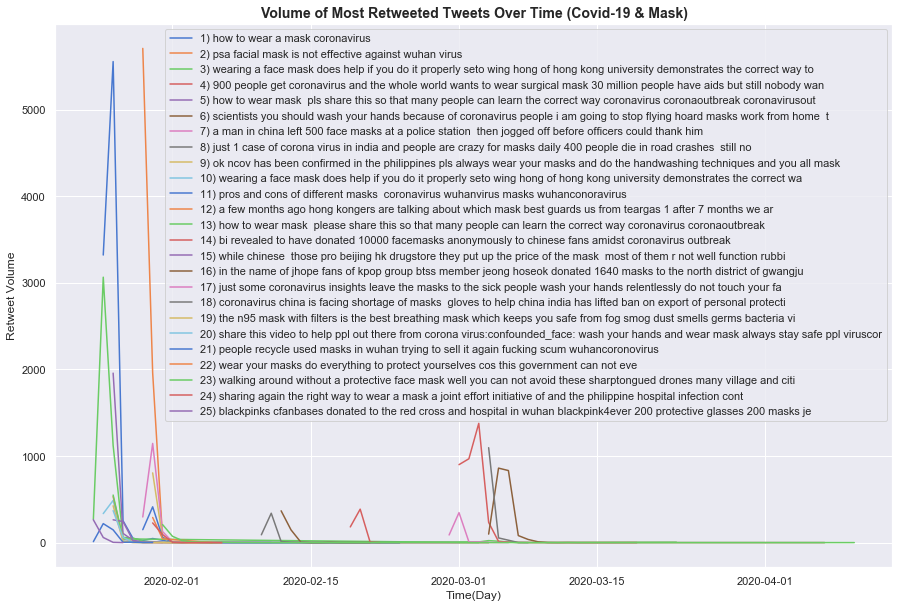

In [244]:
sns.set()
sns.set_palette('muted')
columns = list(df_tweet_freq['tweet'])
legend_labels = []
plt.figure(figsize=(15, 10))
for i in range(len(columns)):
    tweet = columns[i]
    label = str(i+1) + ")" + " " + tweet[:-1]
    legend_labels.append(label)
    df_sub = df_masks.loc[df_masks['cleaned_text'].eq(tweet)]
    df_date = pd.DataFrame(pd.to_datetime(df_sub['created_at']).dt.floor('d').value_counts().rename_axis('created_at').reset_index(name='count')).set_index('created_at')
    df_date = df_date.sort_index()
    plt.plot(df_date)

plt.title('Volume of Most Retweeted Tweets Over Time (Covid-19 & Mask)', fontsize=14, fontweight="bold")
plt.xlabel('Time(Day)')
plt.ylabel('Retweet Volume')
plt.legend(legend_labels)
plt.savefig('tweet_freq_graph.png', dpi=300)


# Word Frequency Distribution

In [315]:
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from nltk import FreqDist
from nltk.tokenize import TweetTokenizer
from nltk.corpus import stopwords
from nltk import word_tokenize
# tt = TweetTokenizer()

stop_words = list(set(stopwords.words('english')))

stop_words.extend(["…", ':', '1', '30'])
                 
df_masks['token_text'] = df_masks['cleaned_text'].apply(word_tokenize)
df_masks['token_text'] = df_masks['token_text'].apply(lambda words: [w for w in words if w not in stop_words])


In [318]:
# pd.set_option("display.max_colwidth", 200)
df_tokens = df_masks[['created_at', 'cleaned_text', 'token_text']]
df_tokens.head(10)

,created_at,cleaned_text,token_text
0,2020-01-22 12:25:55,to wear or not to wear mask in china either way cancer is waiting chinapneumonia wuhancoronavirus …,"[wear, wear, mask, china, either, way, cancer, waiting, chinapneumonia, wuhancoronavirus]"
1,2020-01-22 13:45:44,after tons of criticisms cathaypacific finally announce that staff can wear masks banning masks was really crazy oh gosh who made that silly decision before wuhanpneumonia wuhancoronavirus chinavirus chinesepneumonia chinavirus sars2,"[tons, criticisms, cathaypacific, finally, announce, staff, wear, masks, banning, masks, really, crazy, oh, gosh, made, silly, decision, wuhanpneumonia, wuhancoronavirus, chinavirus, chinesepneumonia, chinavirus, sars2]"
2,2020-01-22 14:07:26,to wear or not to wear mask in china either way cancer is waiting chinapneumonia wuhancoronavirus …,"[wear, wear, mask, china, either, way, cancer, waiting, chinapneumonia, wuhancoronavirus]"
3,2020-01-22 14:16:17,flight attendants demanding to wear face masks on all flights worldwide as wuhancoronavirus spreads hongkong,"[flight, attendants, demanding, wear, face, masks, flights, worldwide, wuhancoronavirus, spreads, hongkong]"
4,2020-01-22 14:34:47,to wear or not to wear mask in china either way cancer is waiting chinapneumonia wuhancoronavirus …,"[wear, wear, mask, china, either, way, cancer, waiting, chinapneumonia, wuhancoronavirus]"
5,2020-01-22 14:54:01,anecdote amazon ships mmm n95 masks to hk and backlog is now 2 weeks may overtake airpods pro soon,"[anecdote, amazon, ships, mmm, n95, masks, hk, backlog, 2, weeks, may, overtake, airpods, pro, soon]"
6,2020-01-22 14:52:57,all people in public places in wuhan are now required to wear masks local government says this after china health offici…,"[people, public, places, wuhan, required, wear, masks, local, government, says, china, health, offici…]"
7,2020-01-22 14:30:42,to wear or not to wear mask in china either way cancer is waiting chinapneumonia wuhancoronavirus …,"[wear, wear, mask, china, either, way, cancer, waiting, chinapneumonia, wuhancoronavirus]"
8,2020-01-22 14:26:40,to wear or not to wear mask in china either way cancer is waiting chinapneumonia wuhancoronavirus …,"[wear, wear, mask, china, either, way, cancer, waiting, chinapneumonia, wuhancoronavirus]"
9,2020-01-22 15:24:53,just put on your masks please hkers do not underestimate the wuhancoronavirus it targets on hk protestors as well by residentevilccp,"[put, masks, please, hkers, underestimate, wuhancoronavirus, targets, hk, protestors, well, residentevilccp]"


In [313]:
token_list = []
df_masks['token_text'].apply(lambda x: token_list.extend(x))
freq_dist = FreqDist(token_list)
df_freq = pd.DataFrame(np.array(freq_dist.most_common(25)), columns = ['word', 'frequency'] )
df_freq = df_freq.astype({'frequency': 'int64', 'word': 'category'})
df_freq = df_freq.set_index('word')

<Figure size 432x288 with 0 Axes>

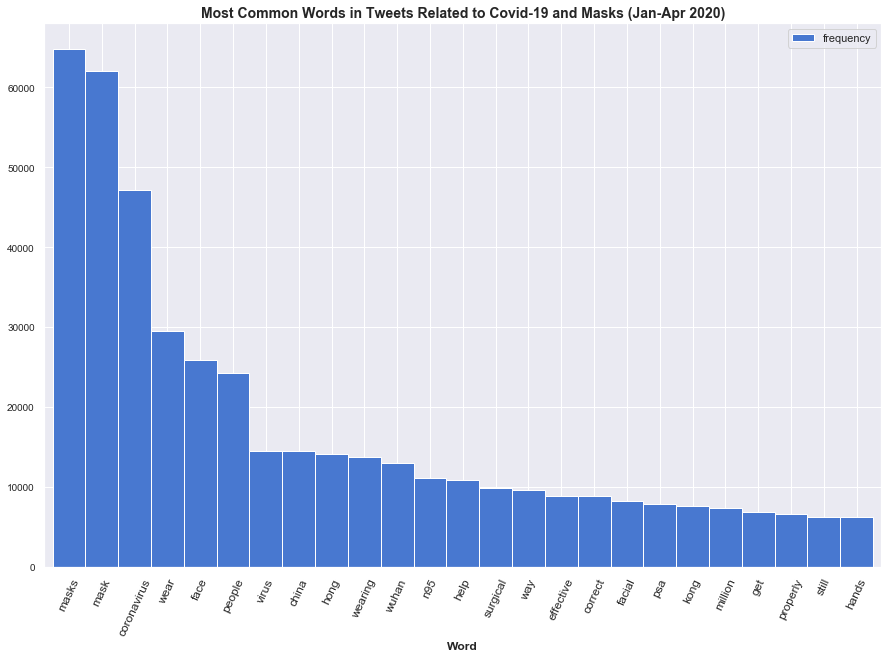

In [314]:
sns.set()
sns.set_palette('muted')

plt.figure()
ax = df_freq.plot(figsize=(15, 10),width=1,kind="bar", fontsize=10, align="center")
ax.set_title("Most Common Words in Tweets Related to Covid-19 and Masks (Jan-Apr 2020)", fontsize=14, fontweight='bold')
ax.set_xlabel('Word', fontsize=12, fontweight="bold")
# ax.set_ylabel('Count', fontsize=12, fontweight="bold")
plt.xticks(rotation=65, fontsize= 12)
plt.savefig('word_freq_graph.png', dpi=300)

# Twitter Covid Mask Sentiment Prediction Model

In [ ]:
tokenizer = Tokenizer(num_words=vocab_size, split=' ')
tokenizer.fit_on_texts(df_masks['cleaned_text'].values)
x_masks = tokenizer.texts_to_sequences(df_masks['cleaned_text'].values)
x_masks = pad_sequences(x_masks,maxlen=89)

df_masks['vectorized'] = None
# print(len(df_masks))
# print(len(x_masks))

for index,row in df_masks.iterrows():
    df_masks.at[index,'vectorized'] = x_masks[index]
    

In [251]:
df_masks['predicted'] = None
df_masks['predicted_label'] = None
for i,row in df_masks.iterrows():
    prediction = model.predict(np.array([df_masks.at[i,'vectorized']]))
    predicted_label = text_labels[np.argmax(prediction[0])]
    df_masks.at[i,'predicted'] = predicted_label
    if predicted_label == 1:
        df_masks.at[i, 'predicted_label'] = "Non-Negative"
    else:
        df_masks.at[i, 'predicted_label'] = "Negative"
# print(df_masks.at[i, 'cleaned_text'], df_masks.at[i, 'predicted_label'])
df_masks.head()

,created_at,id_str,full_text,user_id,cleaned_text,token_text,vectorized,predicted,predicted_label
0,2020-01-22 12:25:55,1219959373339906048,"RT @SaintBurno: To wear or not to wear mask in #China. Either way, #cancer is waiting. #ChinaPneumonia\n#WuhanCoronavirus\nhttps://t.co/JHCex…",1183485916821590016,to wear or not to wear mask in china either way cancer is waiting chinapneumonia wuhancoronavirus …,"[wear, wear, mask, china, either, way, cancer, waiting, chinapneumonia, wuhancoronavirus]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 13, 88, 12, 2, 13, 4, 8, 24, 1278, 39, 2303, 10, 1149, 1159, 272, 64]",1,Non-Negative
1,2020-01-22 13:45:44,1219979461224873984,"After tons of criticisms, #CathayPacific finally announce that staff can wear masks! \n\nBanning masks was really crazy! Oh gosh! Who made that silly decision before? \n\nhttps://t.co/ueutiSxqhO\n\n#WuhanPneumonia #WuhanCoronavirus #ChinaVirus #ChinesePneumonia #ChinaVirus #SARS2",885536695046754304,after tons of criticisms cathaypacific finally announce that staff can wear masks banning masks was really crazy oh gosh who made that silly decision before wuhanpneumonia wuhancoronavirus chinavirus chinesepneumonia chinavirus sars2,"[tons, criticisms, cathaypacific, finally, announce, staff, wear, masks, banning, masks, really, crazy, oh, gosh, made, silly, decision, wuhanpneumonia, wuhancoronavirus, chinavirus, chinesepneumonia, chinavirus, sars, 2]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 123, 809, 6, 1055, 2986, 25, 305, 42, 13, 3, 1540, 3, 101, 225, 230, 1160, 86, 191, 25, 3073, 2529, 131, 1...",0,Negative
2,2020-01-22 14:07:26,1219984924897243136,"RT @SaintBurno: To wear or not to wear mask in #China. Either way, #cancer is waiting. #ChinaPneumonia\n#WuhanCoronavirus\nhttps://t.co/JHCex…",1165459197242163202,to wear or not to wear mask in china either way cancer is waiting chinapneumonia wuhancoronavirus …,"[wear, wear, mask, china, either, way, cancer, waiting, chinapneumonia, wuhancoronavirus]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 13, 88, 12, 2, 13, 4, 8, 24, 1278, 39, 2303, 10, 1149, 1159, 272, 64]",1,Non-Negative
3,2020-01-22 14:16:17,1219987150629896192,.@cathaypacific flight attendants demanding to wear face masks on all flights worldwide as #WuhanCoronavirus spreads https://t.co/Enowrk4win #hongkong,83770449,flight attendants demanding to wear face masks on all flights worldwide as wuhancoronavirus spreads hongkong,"[flight, attendants, demanding, wear, face, masks, flights, worldwide, wuhancoronavirus, spreads, hongkong]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 645, 1750, 3445, 2, 13, 11, 3, 28, 58, 788, 1262, 56, 272, 757, 251]",0,Negative
4,2020-01-22 14:34:47,1219991805241880576,"RT @SaintBurno: To wear or not to wear mask in #China. Either way, #cancer is waiting. #ChinaPneumonia\n#WuhanCoronavirus\nhttps://t.co/JHCex…",996786531816824832,to wear or not to wear mask in china either way cancer is waiting chinapneumonia wuhancoronavirus …,"[wear, wear, mask, china, either, way, cancer, waiting, chinapneumonia, wuhancoronavirus]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 13, 88, 12, 2, 13, 4, 8, 24, 1

In [310]:
df_test = df_masks[['cleaned_text', 'predicted_label']]
df_test.head()

,cleaned_text,predicted_label
0,to wear or not to wear mask in china either way cancer is waiting chinapneumonia wuhancoronavirus …,Non-Negative
1,after tons of criticisms cathaypacific finally announce that staff can wear masks banning masks was really crazy oh gosh who made that silly decision before wuhanpneumonia wuhancoronavirus chinavirus chinesepneumonia chinavirus sars2,Negative
2,to wear or not to wear mask in china either way cancer is waiting chinapneumonia wuhancoronavirus …,Non-Negative
3,flight attendants demanding to wear face masks on all flights worldwide as wuhancoronavirus spreads hongkong,Negative
4,to wear or not to wear mask in china either way cancer is waiting chinapneumonia wuhancoronavirus …,Non-Negative


In [252]:
df_masks['predicted_label'].value_counts()

Negative        92627
Non-Negative    31650
Name: predicted_label, dtype: int64

In [253]:
df_pred = df_masks[['created_at', 'predicted_label']]

df_pred.head()

,created_at,predicted_label
0,2020-01-22 12:25:55,Non-Negative
1,2020-01-22 13:45:44,Negative
2,2020-01-22 14:07:26,Non-Negative
3,2020-01-22 14:16:17,Negative
4,2020-01-22 14:34:47,Non-Negative


<Figure size 432x288 with 0 Axes>

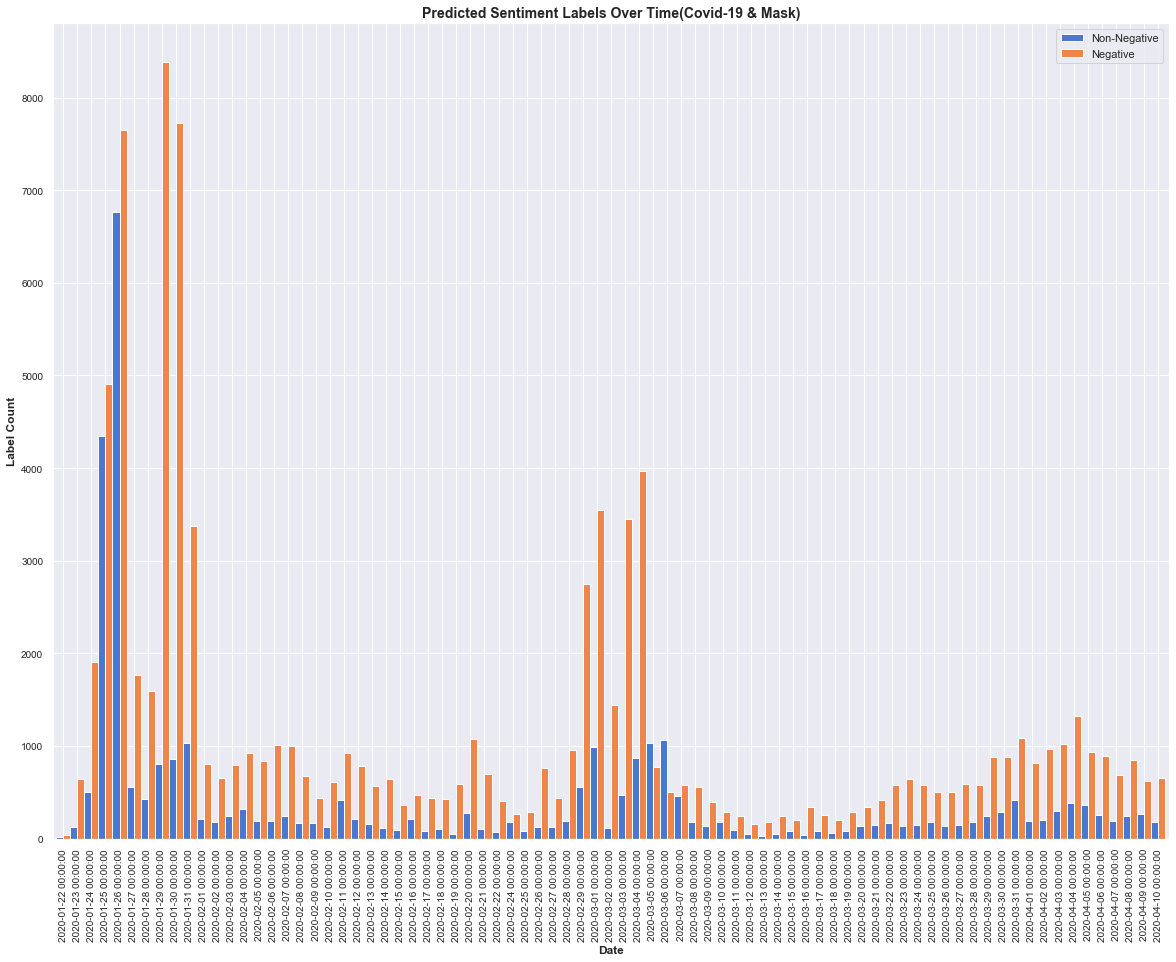

In [308]:
sns.set()
sns.set_palette('muted')
legend_labels = []
plt.figure()


df_non = df_masks.loc[df_pred['predicted_label'].eq('Non-Negative')]
df_non = pd.DataFrame(pd.to_datetime(df_non['created_at']).dt.floor('d').value_counts().rename_axis('created_at').reset_index(name='Non-Negative')).set_index('created_at')
df_neg = df_masks.loc[df_pred['predicted_label'].eq('Negative')]
df_neg = pd.DataFrame(pd.to_datetime(df_neg['created_at']).dt.floor('d').value_counts().rename_axis('created_at').reset_index(name='Negative')).set_index('created_at')

df_graph = pd.concat([df_non, df_neg], axis=1)
df_graph = df_graph.sort_index()
ax = df_graph.plot(figsize=(20, 15),width=1,kind="bar", fontsize=10, align="center")
ax.set_xlabel('Date', fontsize=12, fontweight="bold")
ax.set_ylabel('Label Count', fontsize=12, fontweight="bold")

plt.title('Predicted Sentiment Labels Over Time(Covid-19 & Mask)', fontsize=14, fontweight="bold")
plt.legend(['Non-Negative', 'Negative'])
# plt.xticks(rotation=65, fontsize= 12)
plt.savefig('mask_sentiment_predictions_graph.png', dpi=250)

In [ ]:
df_masks.drop(['predictedLabel'],axis=1,inplace=True)
df_masks.to_csv('covid_mask_twitter_predictions.csv', index=False)

## Clustering

In [109]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans


model = KMeans(n_clusters=2, max_iter=1000, random_state=True, n_init=50).fit(X=word_vectors.vectors)

13224


In [110]:
print(X[0])
print(X[1])

[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0  528    4   15
 1160 2391    1    3  181]
[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   2  71   9  89 722 549   2  66   1 138 136 175]
